# NEK_9 Data Visualization
## Chongye Feng

In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools

imblearn version:  0.11.0


In [3]:
# Binding
dataset_path = '../../data/NEK_data_4Berkeley/NEK9/'
nek9_binding_random_imbalanced = 'NEK9_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df_binding = pd.read_csv(dataset_path+nek9_binding_random_imbalanced)
all_fold_df_binding.shape # (1409,310)

(1409, 310)

In [4]:
# Inhibition
nek9_inhibition_random_imbalanced = 'NEK9_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
all_fold_df_inhibition = pd.read_csv(dataset_path+nek9_inhibition_random_imbalanced)
all_fold_df_inhibition.shape  # (393, 310)

(393, 310)

In [5]:
combined_df = pd.concat([all_fold_df_binding, all_fold_df_inhibition ])
value_counts = combined_df[('compound_id')].value_counts()
value_counts

compound_id
kdb_2222    2
kdb_2215    2
kdb_2230    2
kdb_2235    2
kdb_2236    2
           ..
kdb_148     1
kdb_2781    1
kdb_3485    1
kdb_53      1
kdb_3758    1
Name: count, Length: 1755, dtype: int64

In [6]:
in_both = value_counts[value_counts==2]
in_both

compound_id
kdb_2222    2
kdb_2215    2
kdb_2230    2
kdb_2235    2
kdb_2236    2
kdb_2218    2
kdb_2431    2
kdb_2244    2
kdb_2233    2
kdb_2217    2
kdb_2430    2
kdb_2205    2
kdb_2229    2
kdb_2238    2
kdb_2211    2
kdb_2232    2
kdb_2320    2
kdb_2234    2
kdb_2225    2
kdb_2433    2
kdb_2237    2
kdb_2200    2
kdb_2208    2
kdb_2212    2
kdb_2228    2
kdb_2207    2
kdb_2206    2
kdb_2319    2
kdb_2429    2
kdb_2219    2
kdb_1618    2
kdb_2224    2
kdb_2241    2
kdb_2601    2
kdb_2209    2
kdb_2227    2
kdb_2221    2
kdb_2213    2
kdb_2220    2
kdb_2242    2
kdb_2223    2
kdb_2908    2
kdb_2239    2
kdb_2013    2
kdb_2321    2
kdb_2226    2
kdb_2231    2
Name: count, dtype: int64

In [7]:
len(in_both)

47

There are 47 compounds in both binding and inhibition data set.

In [8]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
binding_df = pd.read_csv('../../data/datasets/scaled_descriptors/NEK9_1_uM_min_50_pct_binding_with_moe_descriptors.csv')
print(binding_df.shape)

(1409, 309)


In [10]:
moe_columns = binding_df.columns[3:]
moe_columns

Index(['ASA+_per_atom', 'ASA-', 'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom',
       'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3',
       'BCUT_SLOGP_0_per_atom',
       ...
       'vsurf_Wp2_per_atom', 'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5',
       'vsurf_Wp6', 'vsurf_Wp7', 'vsurf_Wp8', 'weinerPath',
       'weinerPol_per_atom', 'zagreb_per_atom'],
      dtype='object', length=306)

There are 306 features (parameters) for each compound.

In [11]:
inhibition_df = pd.read_csv('../../data/datasets/scaled_descriptors/NEK9_1_uM_min_50_pct_inhibition_with_moe_descriptors.csv') 
inhibition_df.shape

(393, 309)

Now, we will look at the pre-splitted inhibition data for NEK9.

In [12]:
uq_path = '../../data/NEK_data_4Berkeley/NEK9/'
train_x_df = pd.read_csv(uq_path+'NEK9_inhibition_random_fold1_trainX.csv')
train_y_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_trainY.csv")
test_x_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_testX.csv")
test_y_df= pd.read_csv(uq_path+"/NEK9_inhibition_random_fold1_testY.csv")
print(train_y_df.value_counts()), print(test_y_df.value_counts())
print(train_y_df.shape, test_y_df.shape)
print(train_x_df.shape, test_x_df.shape)

active
0         280
1          33
Name: count, dtype: int64
active
0         71
1          9
Name: count, dtype: int64
(313, 1) (80, 1)
(313, 306) (80, 306)


306 features are still too much. 

In [13]:
# Concatenation of Training and Testing Feature Sets:
x_df = pd.concat([train_x_df, test_x_df])
# Feature Scaling using StandardScaler:
scaling = StandardScaler()
scaling.fit(x_df)
Scaled_data = scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df)

Dimensionality Reduction using PCA:
This means PCA will choose the number of components such that the total variance explained by those components is at least 95% of the total variance in the dataset. This approach automatically selects the number of principal components needed to retain 95% of the data's variance, effectively reducing the dimensionality of the data while preserving most of the information.


In [14]:
principal = PCA(n_components=0.95) 
principal.fit(Scaled_data)
pca_train_x_df = principal.transform(train_scaled_data)
pca_test_x_df = principal.transform(test_scaled_data)

In [15]:
print(pca_train_x_df.shape)
print(pca_test_x_df.shape)

(313, 52)
(80, 52)


306 was significantly reduced to 52.

Then use SMOTE (Synthetic Minority Over-sampling Technique) to adjust for imbalanced class distributions in the training dataset. This is a common scenario in many machine learning problems where one class (the minority class) has significantly fewer instances than the other classes (the majority classes), leading to biased models that favor the majority class. SMOTE addresses this issue by creating synthetic examples of the minority class, thus balancing the class distribution and potentially improving model performance on minority class predictions.

In [16]:
# SMOTE Initialization:
oversample = SMOTE()

# Applying SMOTE to the Training Data:
new_train_x_df, new_train_y_df = oversample.fit_resample(pca_train_x_df, train_y_df)

In [17]:
import torch

# Convert the feature arrays directly to PyTorch tensors and cast them to the appropriate type.
train_x = torch.from_numpy(new_train_x_df).long()
test_x = torch.from_numpy(pca_test_x_df).long()

# For the labels, which are pandas DataFrames, first convert them to numpy arrays, then cast to "long",
# and finally convert to PyTorch tensors.
train_y = torch.from_numpy(new_train_y_df.to_numpy().astype("long")).reshape(-1)
test_y = torch.from_numpy(test_y_df.to_numpy().astype("long")).reshape(-1)

# Print the shapes of the tensors to ensure they are correct.
print(f"Shape of training features tensor: {train_x.shape}")
print(f"Shape of training labels tensor: {train_y.shape}")

Shape of training features tensor: torch.Size([560, 52])
Shape of training labels tensor: torch.Size([560])


Then we build a model.

In [18]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

Training the model ...

In [19]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/300 - Loss: 7.041   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.293   lengthscale: 0.975   noise: 0.971
Iter 11/300 - Loss: 5.738   lengthscale: 1.320   noise: 1.286
Iter 16/300 - Loss: 5.321   lengthscale: 1.729   noise: 1.583
Iter 21/300 - Loss: 5.013   lengthscale: 2.200   noise: 1.795
Iter 26/300 - Loss: 4.785   lengthscale: 2.715   noise: 1.876
Iter 31/300 - Loss: 4.604   lengthscale: 3.246   noise: 1.821
Iter 36/300 - Loss: 4.439   lengthscale: 3.773   noise: 1.649
Iter 41/300 - Loss: 4.277   lengthscale: 4.288   noise: 1.393
Iter 46/300 - Loss: 4.121   lengthscale: 4.785   noise: 1.095
Iter 51/300 - Loss: 3.979   lengthscale: 5.254   noise: 0.799
Iter 56/300 - Loss: 3.858   lengthscale: 5.681   noise: 0.546
Iter 61/300 - Loss: 3.760   lengthscale: 6.060   noise: 0.357
Iter 66/300 - Loss: 3.687   lengthscale: 6.391   noise: 0.232
Iter 71/300 - Loss: 3.635   lengthscale: 6.675   noise: 0.156
Iter 76/300 - Loss: 3.599   lengthscale: 6.920   noise: 0.111
Iter 81/30

In [20]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(train_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(train_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

(2, 560)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1,

/home/chongyef/miniconda3/envs/atom2024/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Building the confusion plot

Confusion matrix, without normalization
[[276   4]
 [  0 280]]


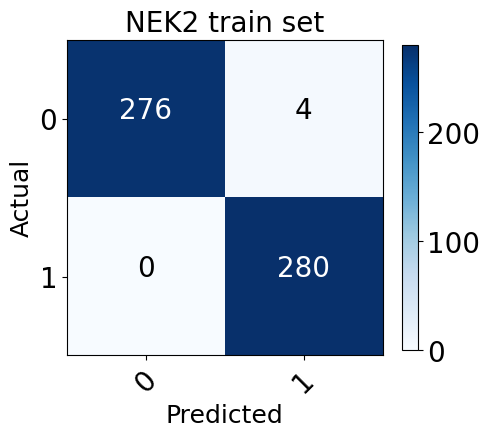

In [21]:
train_prediction = model(train_x).loc.max(0)[1].numpy()
y_true = new_train_y_df.values
y_pred = train_prediction
train_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

In [22]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(test_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

(2, 80)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1])


In [23]:
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(80,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

Confusion matrix, without normalization
[[70  1]
 [ 2  7]]


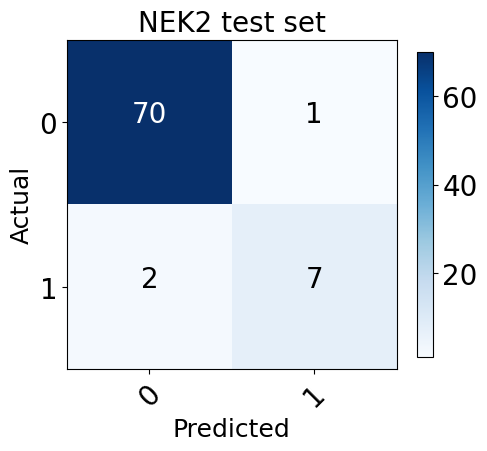

In [24]:
y_true = test_y_df.values
y_pred = test_prediction
test_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Which could be acceptable. Then we see the uncertainty:

In [25]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 1.7071,  1.7208,  1.4347,  1.7808,  1.0801,  1.6146,  1.6415,  1.5652,
          1.8763,  1.3305,  1.4688,  2.3387,  1.6645,  1.2269,  0.8301,  2.2195,
          1.3350,  1.6672,  1.8747,  1.9580,  1.6495,  1.2398,  2.0431,  1.3839,
         -0.0566,  1.3923,  1.5143,  1.4385,  1.9946,  2.3910,  1.2998,  1.7533,
          2.0554,  1.8001,  1.1161,  1.0540,  1.9469,  1.7380,  1.3160,  2.0762,
          0.9934,  1.7939,  1.9636,  2.3741,  2.0912,  1.9901,  2.2769,  0.8791,
          2.1235,  1.3500,  2.2874,  1.5044,  1.7989,  1.0483,  1.2555,  1.6894,
          1.8195,  2.3972,  0.9065,  2.4645,  1.7494,  0.9190,  1.9948,  1.8515,
         -3.0756,  1.3150,  1.9558,  1.3166,  1.8978,  2.3622,  0.7212, -2.4802,
          0.7882, -4.4226, -1.0178, -4.9339,  2.4251, -1.5956, -2.6969, -4.4942],
        [-3.3435, -5.1595, -4.0652, -3.4214, -2.1284, -4.0562, -4.3867, -4.0145,
         -5.0156, -2.0411, -5.2268, -3.4160, -3.0994, -4.2260, -2.8485, -5.3715,
         -4.8650, -4.6215, 

In [26]:
observed_pred.mean.numpy()

array([[-7.4759984e-01,  6.2105060e-04, -3.6348036e-01, -7.3697996e-01,
        -1.3819344e+00, -3.5727528e-01, -3.5818914e-01, -4.5867899e-01,
        -2.4407580e-01, -1.2112734e+00, -2.1690181e-01, -3.7940481e-01,
        -7.3664355e-01, -5.1920199e-01, -1.1798246e+00, -4.6899915e-04,
        -6.8694383e-02, -1.7356089e-01, -4.7744587e-01, -2.3236707e-01,
        -3.0212635e-01, -5.4676795e-01, -1.6890410e-01, -8.9243102e-01,
        -2.3294652e+00, -5.3373313e-01, -6.5581441e-01, -8.1665969e-01,
        -5.3655887e-01,  1.8700191e-01, -1.0346200e+00, -2.0881370e-01,
        -2.2286919e-01, -5.2418733e-01, -1.0626595e+00, -1.5214612e+00,
        -1.0367635e-01, -3.0390003e-01, -1.1986811e+00, -1.8644837e-01,
        -8.6575484e-01, -2.8533056e-01, -3.9277875e-01, -4.2047474e-01,
        -2.6393524e-01, -2.0392111e-01, -3.5608235e-01, -9.5746493e-01,
        -3.0235115e-01, -2.2153071e-01, -1.1093810e-01, -3.0755296e-01,
        -2.4925759e-01, -8.0967879e-01, -6.8259883e-01, -3.72344

In [27]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities

tensor([[0.9815, 0.9980, 0.9920, 0.9810, 0.9259, 0.9911, 0.9957, 0.9920, 0.9974,
         0.9272, 0.9976, 0.9887, 0.9800, 0.9928, 0.9534, 0.9986, 0.9980, 0.9963,
         0.9836, 0.9967, 0.9959, 0.9852, 0.9947, 0.9581, 0.6525, 0.9937, 0.9888,
         0.9689, 0.9843, 0.9975, 0.9344, 0.9964, 0.9913, 0.9923, 0.9570, 0.8708,
         0.9965, 0.9956, 0.9080, 0.9959, 0.9488, 0.9948, 0.9892, 0.9814, 0.9909,
         0.9972, 0.9876, 0.9732, 0.9953, 0.9927, 0.9921, 0.9962, 0.9967, 0.9872,
         0.9901, 0.9917, 0.9815, 0.9944, 0.9525, 0.9924, 0.9972, 0.8092, 0.9976,
         0.9956, 0.0375, 0.9974, 0.9900, 0.9870, 0.9844, 0.9894, 0.9687, 0.0669,
         0.9354, 0.0072, 0.3278, 0.0042, 0.9807, 0.1998, 0.0216, 0.0079],
        [0.0185, 0.0020, 0.0080, 0.0190, 0.0741, 0.0089, 0.0043, 0.0080, 0.0026,
         0.0728, 0.0024, 0.0113, 0.0200, 0.0072, 0.0466, 0.0014, 0.0020, 0.0037,
         0.0164, 0.0033, 0.0041, 0.0148, 0.0053, 0.0419, 0.3475, 0.0063, 0.0112,
         0.0311, 0.0157, 0.0025, 0.

In [28]:
# Assuming observed_pred is a MultivariateNormal object from GPyTorch
num_predictions = observed_pred.mean.shape[1]
print(f"Number of predictions: {num_predictions}")

Number of predictions: 80


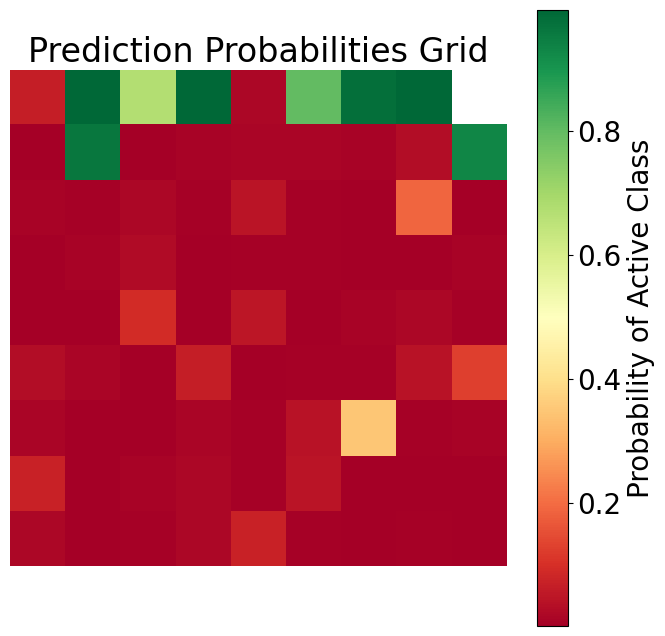

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'probabilities' is your tensor of shape [2, num_samples]
# Convert the tensor to a numpy array for easier manipulation if it's not already
probabilities_np = probabilities.numpy()

# Since you're interested in showing the active class probability,
# we'll use the second row ([1]) which represents the probability of being "active"
active_probabilities = probabilities_np[1, :]

# Prepare the data for plotting
# The data needs to be reshaped into a 2D array where each "pixel" or cell in the plot
# represents the probability of a sample being "active"
# For demonstration, let's assume a square grid as much as possible
num_samples = active_probabilities.shape[0]
side_length = int(np.ceil(np.sqrt(num_samples)))  # Calculate the side length of the grid

# Create a 2D array filled with NaNs (to be ignored in the plot)
grid_data = np.full((side_length, side_length), np.nan)

# Fill the grid with the active probabilities
# Flatten the grid (if needed) and assign probabilities (ensures alignment even if not a perfect square)
grid_data.flat[:num_samples] = active_probabilities

# Plotting
plt.figure(figsize=(8, 8))
plt.imshow(grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
plt.colorbar(label='Probability of Active Class')
plt.title('Prediction Probabilities Grid')
plt.axis('off')  # Turn off the axis for a clean look

plt.show()

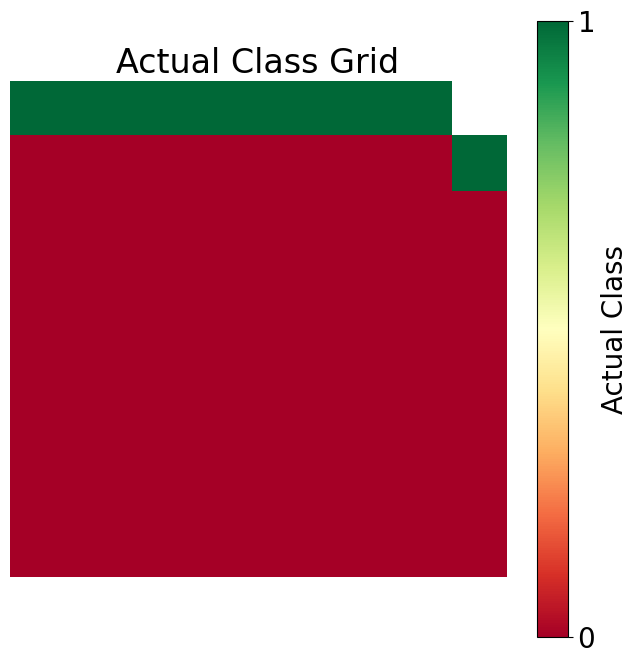

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `y_true` contains the actual class labels
actual_classes = y_true  # If y_true is not a numpy array, convert it: np.array(y_true)

# Prepare the data for plotting
# The data needs to be reshaped into a 2D array where each "pixel" or cell in the plot
# represents the actual class of a sample
num_samples = actual_classes.shape[0]
side_length = int(np.ceil(np.sqrt(num_samples)))  # Calculate the side length of the grid

# Create a 2D array filled with NaNs (to be ignored in the plot)
grid_data = np.full((side_length, side_length), np.nan)

# Fill the grid with the actual classes
# Flatten the grid (if needed) and assign actual class labels (ensures alignment even if not a perfect square)
grid_data.flat[:num_samples] = actual_classes

# Plotting
plt.figure(figsize=(8, 8))
plt.imshow(grid_data, cmap='RdYlGn', origin='lower', aspect='equal')
plt.colorbar(ticks=[0, 1], label='Actual Class')
plt.clim(0, 1)  # Ensure the colorbar covers 0 to 1 to represent the classes clearly
plt.title('Actual Class Grid')
plt.axis('off')  # Turn off the axis for a clean look

plt.show()